# Insurance Fraud Detection System

## Project Overview
This project aims to develop an automatic fraud detection system using machine learning techniques to analyze insurance claims data and detect suspicious activities.

### Objectives:
- Develop a machine learning model that detects fraud
- Improve detection accuracy via advanced data preprocessing and feature engineering
- Compare multiple ML models and select the best performing one
- Create visualizations for model performance and data insights
- Ensure robust evaluation with proper train/test split

## 1. Import Required Libraries

In [1]:
!pip install lightgbm
!pip install imblearn


In [2]:
!pip install pyspark

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

# Feature engineering and selection
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA

# Imbalanced data handling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Utilities
import warnings
import joblib
from datetime import datetime
import re

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Data Loading and Initial Exploration

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import plotly.graph_objects as go

In [27]:
from pyspark.sql import SparkSession
import time

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Insurance Fraud Detection") \
    .getOrCreate()

# File path (use raw string or double backslashes)
file_path = r"D:\data\6th sem\Big data analytics\car insurance fraud\insurance_fraud_detection\insurance_claims.csv"

# Start timer
start_time = time.time()

# Load the dataset
df = spark.read.csv(file_path, header=True, inferSchema=True)

# End timer
end_time = time.time()

# Print dataset details
print(f"\nTime taken to load the dataset: {end_time - start_time:.2f} seconds")
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")
print("\nColumns:")
print(", ".join(df.columns))

print("\nSample Data:")
df.show(5, truncate=False)



Time taken to load the dataset: 0.14 seconds
Number of rows: 1000
Number of columns: 39

Columns:
months_as_customer, age, policy_number, policy_bind_date, policy_state, policy_csl, policy_deductable, policy_annual_premium, umbrella_limit, insured_zip, insured_sex, insured_education_level, insured_occupation, insured_hobbies, insured_relationship, capital-gains, capital-loss, incident_date, incident_type, collision_type, incident_severity, authorities_contacted, incident_state, incident_city, incident_location, incident_hour_of_the_day, number_of_vehicles_involved, property_damage, bodily_injuries, witnesses, police_report_available, total_claim_amount, injury_claim, property_claim, vehicle_claim, auto_make, auto_model, auto_year, fraud_reported

Sample Data:
+------------------+---+-------------+----------------+------------+----------+-----------------+---------------------+--------------+-----------+-----------+-----------------------+------------------+---------------+------------

In [6]:
# Dataset info equivalent
print("Dataset Info:")
df.printSchema()

print("\n" + "="*50)

# Statistical summary equivalent
print("Statistical Summary:")
df.describe().show()

Dataset Info:
root
 |-- months_as_customer: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- policy_number: integer (nullable = true)
 |-- policy_bind_date: string (nullable = true)
 |-- policy_state: string (nullable = true)
 |-- policy_csl: string (nullable = true)
 |-- policy_deductable: integer (nullable = true)
 |-- policy_annual_premium: double (nullable = true)
 |-- umbrella_limit: integer (nullable = true)
 |-- insured_zip: integer (nullable = true)
 |-- insured_sex: string (nullable = true)
 |-- insured_education_level: string (nullable = true)
 |-- insured_occupation: string (nullable = true)
 |-- insured_hobbies: string (nullable = true)
 |-- insured_relationship: string (nullable = true)
 |-- capital-gains: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- incident_date: string (nullable = true)
 |-- incident_type: string (nullable = true)
 |-- collision_type: string (nullable = true)
 |-- incident_severity: string (nullable = tru

# Data Cleaning & Transformation

In [8]:
from pyspark.sql.functions import count, when, col

# Count total rows in the DataFrame
row_count = df.count()

# Check for missing values
missing_df = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
])
missing_df.show()

# Calculate missing percentages
missing_percentage_df = missing_df.select([
    ((col(c) / row_count) * 100).alias(c) for c in df.columns
])

# Show columns with missing data percentages
missing_percentage_df.show()


+------------------+---+-------------+----------------+------------+----------+-----------------+---------------------+--------------+-----------+-----------+-----------------------+------------------+---------------+--------------------+-------------+------------+-------------+-------------+--------------+-----------------+---------------------+--------------+-------------+-----------------+------------------------+---------------------------+---------------+---------------+---------+-----------------------+------------------+------------+--------------+-------------+---------+----------+---------+--------------+
|months_as_customer|age|policy_number|policy_bind_date|policy_state|policy_csl|policy_deductable|policy_annual_premium|umbrella_limit|insured_zip|insured_sex|insured_education_level|insured_occupation|insured_hobbies|insured_relationship|capital-gains|capital-loss|incident_date|incident_type|collision_type|incident_severity|authorities_contacted|incident_state|incident_city|i

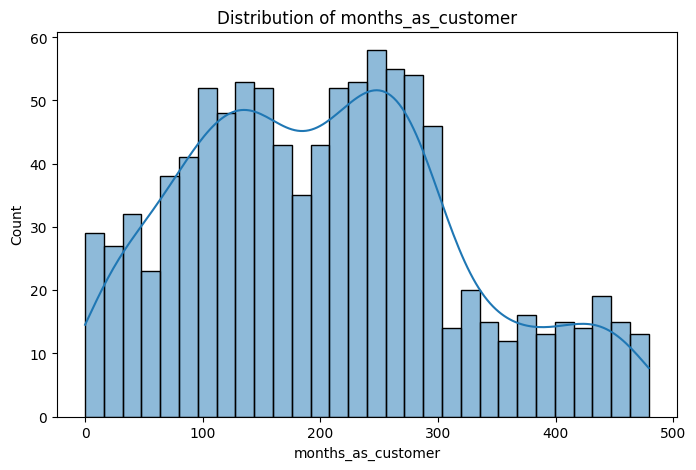

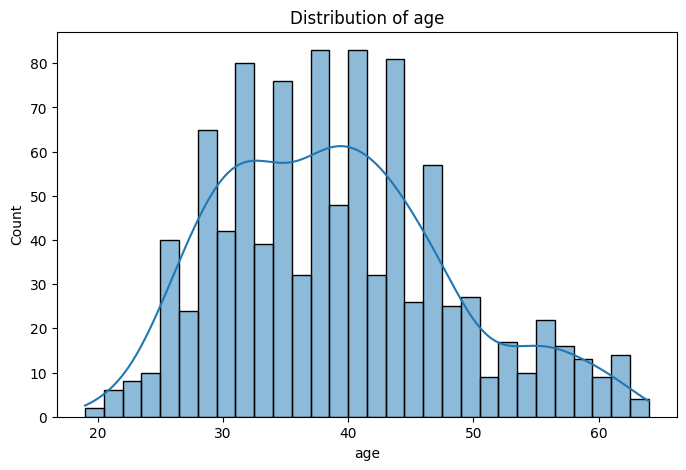

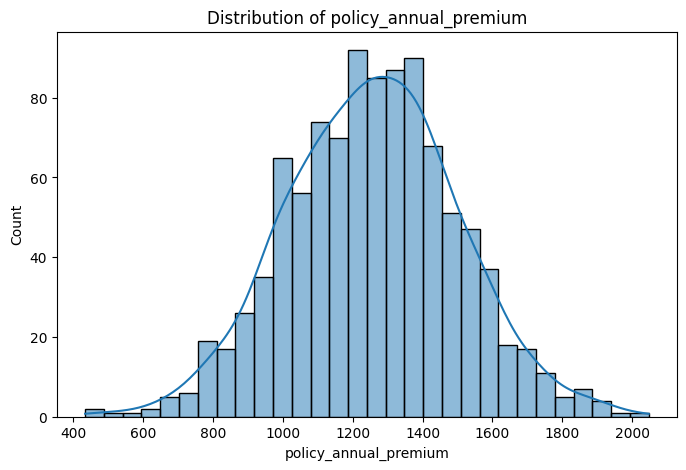

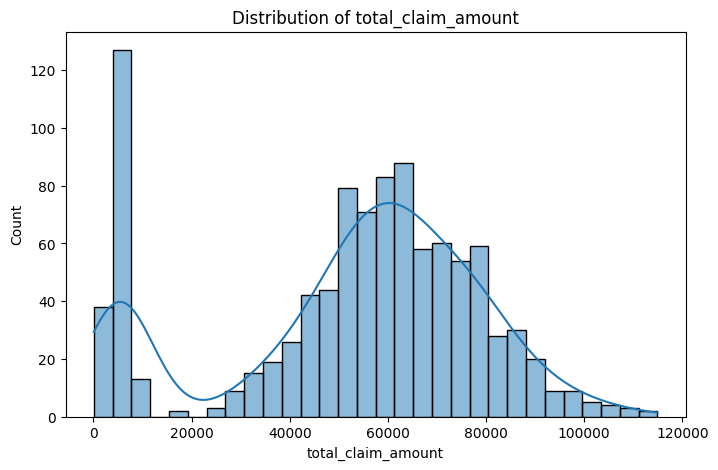

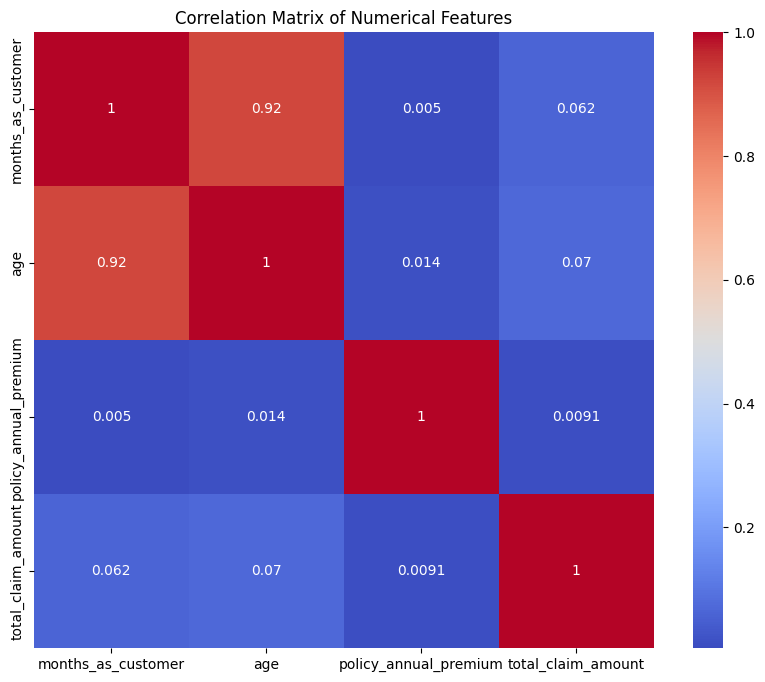

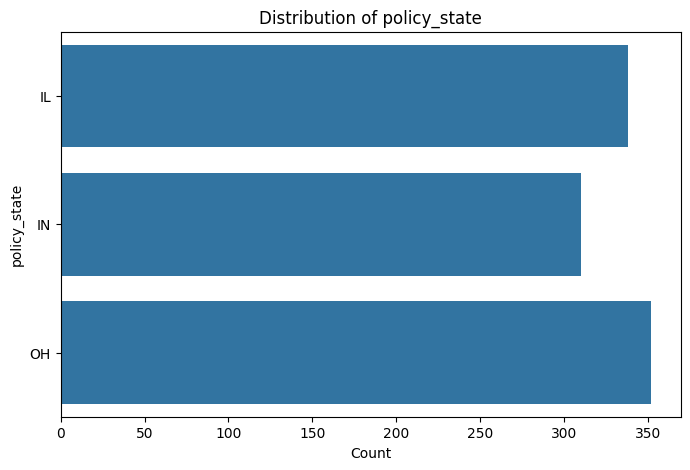

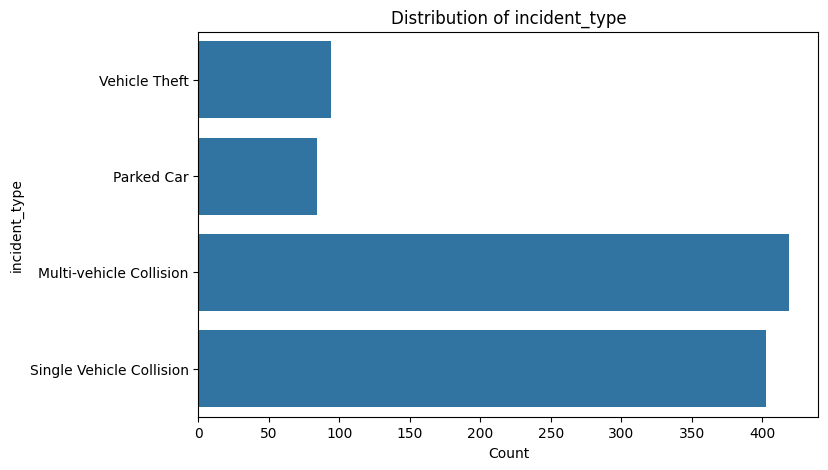

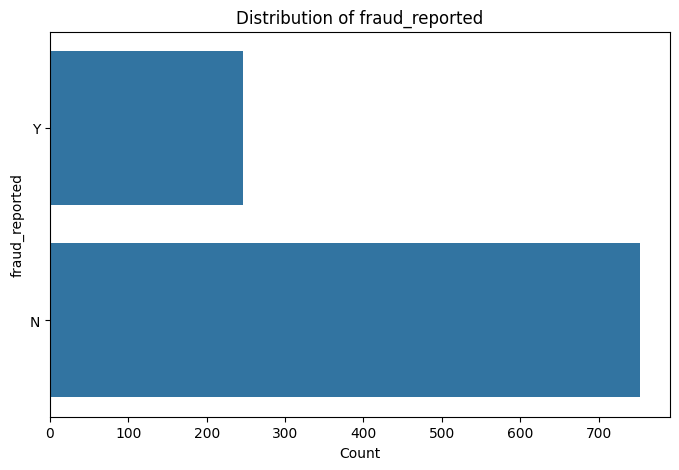

In [22]:
# EDA: Numerical Feature Distributions
numerical_cols = ['months_as_customer', 'age', 'policy_annual_premium', 'total_claim_amount']
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    df_pandas = df.select(col).toPandas()
    sns.histplot(df_pandas[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# EDA: Correlation Analysis
from pyspark.sql.functions import corr
correlation_matrix = pd.DataFrame(index=numerical_cols, columns=numerical_cols)
for col1 in numerical_cols:
    for col2 in numerical_cols:
        correlation_matrix.loc[col1, col2] = df.select(corr(col1, col2)).collect()[0][0]
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# EDA: Categorical Feature Analysis
categorical_cols = ['policy_state', 'incident_type', 'fraud_reported']
for col in categorical_cols:
    df_grouped = df.groupBy(col).count().toPandas()
    plt.figure(figsize=(8, 5))
    sns.barplot(x='count', y=col, data=df_grouped)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

Target Variable Distribution:
Fraud (Y): 247 (24.70%)
No Fraud (N): 753 (75.30%)

Imbalance Ratio (No Fraud : Fraud): 3.05:1
⚠️  Dataset is imbalanced. We'll need to handle this during model training.


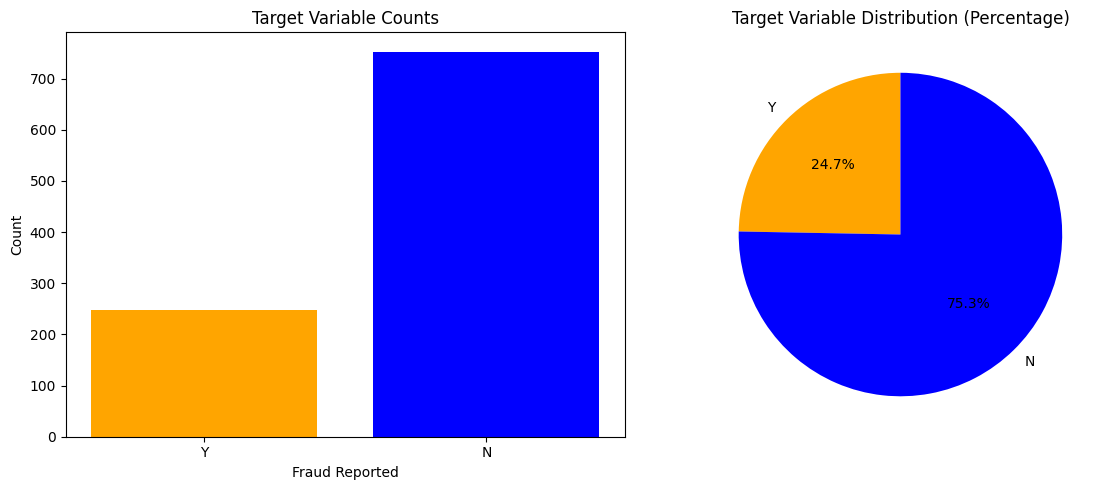

In [30]:
from pyspark.sql.functions import col, count, when
import matplotlib.pyplot as plt
import pandas as pd

# Count the target variable distribution
target_counts_df = df.groupBy("fraud_reported").count()
target_counts = target_counts_df.collect()

# Convert target counts to a dictionary for easier handling
target_counts_dict = {row["fraud_reported"]: row["count"] for row in target_counts}
total_count = sum(target_counts_dict.values())

# Calculate percentages
target_percentage = {k: (v / total_count) * 100 for k, v in target_counts_dict.items()}

# Display target variable distribution
print("Target Variable Distribution:")
print(f"Fraud (Y): {target_counts_dict.get('Y', 0)} ({target_percentage.get('Y', 0):.2f}%)")
print(f"No Fraud (N): {target_counts_dict.get('N', 0)} ({target_percentage.get('N', 0):.2f}%)")

# Check imbalance ratio
imbalance_ratio = (target_counts_dict.get('N', 0) / target_counts_dict.get('Y', 1)) if 'Y' in target_counts_dict else float('inf')
print(f"\nImbalance Ratio (No Fraud : Fraud): {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("⚠️  Dataset is imbalanced. We'll need to handle this during model training.")

# Convert to Pandas for visualization
target_counts_pd = pd.DataFrame(target_counts, columns=["fraud_reported", "count"])

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot for counts
ax1.bar(target_counts_dict.keys(), target_counts_dict.values(), color=['orange', 'blue'])
ax1.set_title('Target Variable Counts')
ax1.set_xlabel('Fraud Reported')
ax1.set_ylabel('Count')
ax1.set_xticks(list(target_counts_dict.keys()))

# Pie chart for percentages
ax2.pie(
    target_percentage.values(),
    labels=target_percentage.keys(),
    autopct='%1.1f%%',
    colors=['orange', 'blue'],
    startangle=90,
)
ax2.set_title('Target Variable Distribution (Percentage)')

# Adjust layout and display plots
plt.tight_layout()
plt.show()


## 3. Exploratory Data Analysis (EDA)

In [31]:
from pyspark.sql.types import NumericType, StringType

# Get the schema of the DataFrame
schema = df.schema

# Separate columns based on their data types
numerical_cols = [field.name for field in schema.fields if isinstance(field.dataType, NumericType)]
categorical_cols = [field.name for field in schema.fields if isinstance(field.dataType, StringType)]

# Remove the target variable from the categorical columns list
if 'fraud_reported' in categorical_cols:
    categorical_cols.remove('fraud_reported')

# Print the results
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")


Numerical columns (18): ['months_as_customer', 'age', 'policy_number', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year']

Categorical columns (20): ['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'property_damage', 'police_report_available', 'auto_make', 'auto_model']


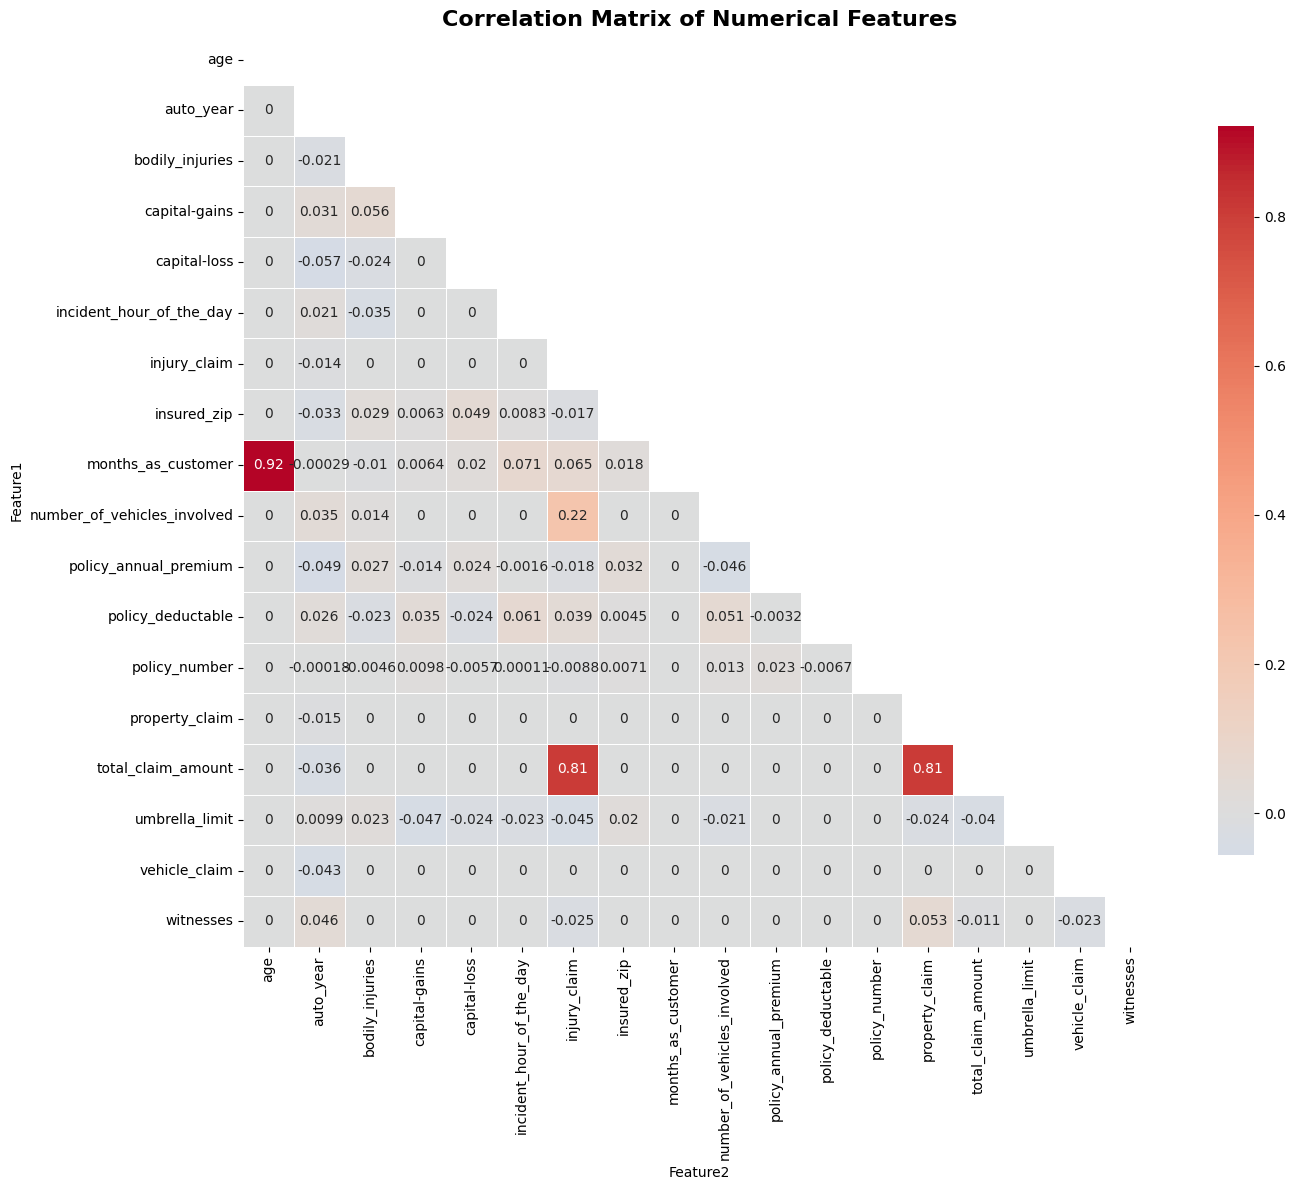


Highly correlated feature pairs (correlation > 0.8):
               Feature1        Feature2  Correlation
1    months_as_customer             age     0.922098
157  total_claim_amount    injury_claim     0.805025
158  total_claim_amount  property_claim     0.810686
159  total_claim_amount   vehicle_claim     0.982773


In [32]:
from pyspark.sql.functions import corr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute correlation matrix for numerical columns
correlation_data = []
numerical_cols = [col for col in df.columns if isinstance(df.schema[col].dataType, NumericType)]

for i in range(len(numerical_cols)):
    for j in range(i, len(numerical_cols)):
        col1 = numerical_cols[i]
        col2 = numerical_cols[j]
        correlation_value = df.select(corr(col1, col2).alias('correlation')).collect()[0]['correlation']
        correlation_data.append((col1, col2, correlation_value))

# Convert correlation data to a DataFrame for easier manipulation
correlation_matrix_df = pd.DataFrame(correlation_data, columns=["Feature1", "Feature2", "Correlation"])

# Pivot to form a matrix
correlation_matrix_pivot = correlation_matrix_df.pivot(index="Feature1", columns="Feature2", values="Correlation")
correlation_matrix_pivot = correlation_matrix_pivot.fillna(0)  # Fill NaN values with 0

# Plot the heatmap
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(correlation_matrix_pivot, dtype=bool))
sns.heatmap(correlation_matrix_pivot, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs
high_corr_pairs = correlation_matrix_df[
    (correlation_matrix_df["Correlation"].abs() > 0.8) & (correlation_matrix_df["Feature1"] != correlation_matrix_df["Feature2"])
]

if not high_corr_pairs.empty:
    print("\nHighly correlated feature pairs (correlation > 0.8):")
    print(high_corr_pairs)
else:
    print("\nNo highly correlated feature pairs found.")


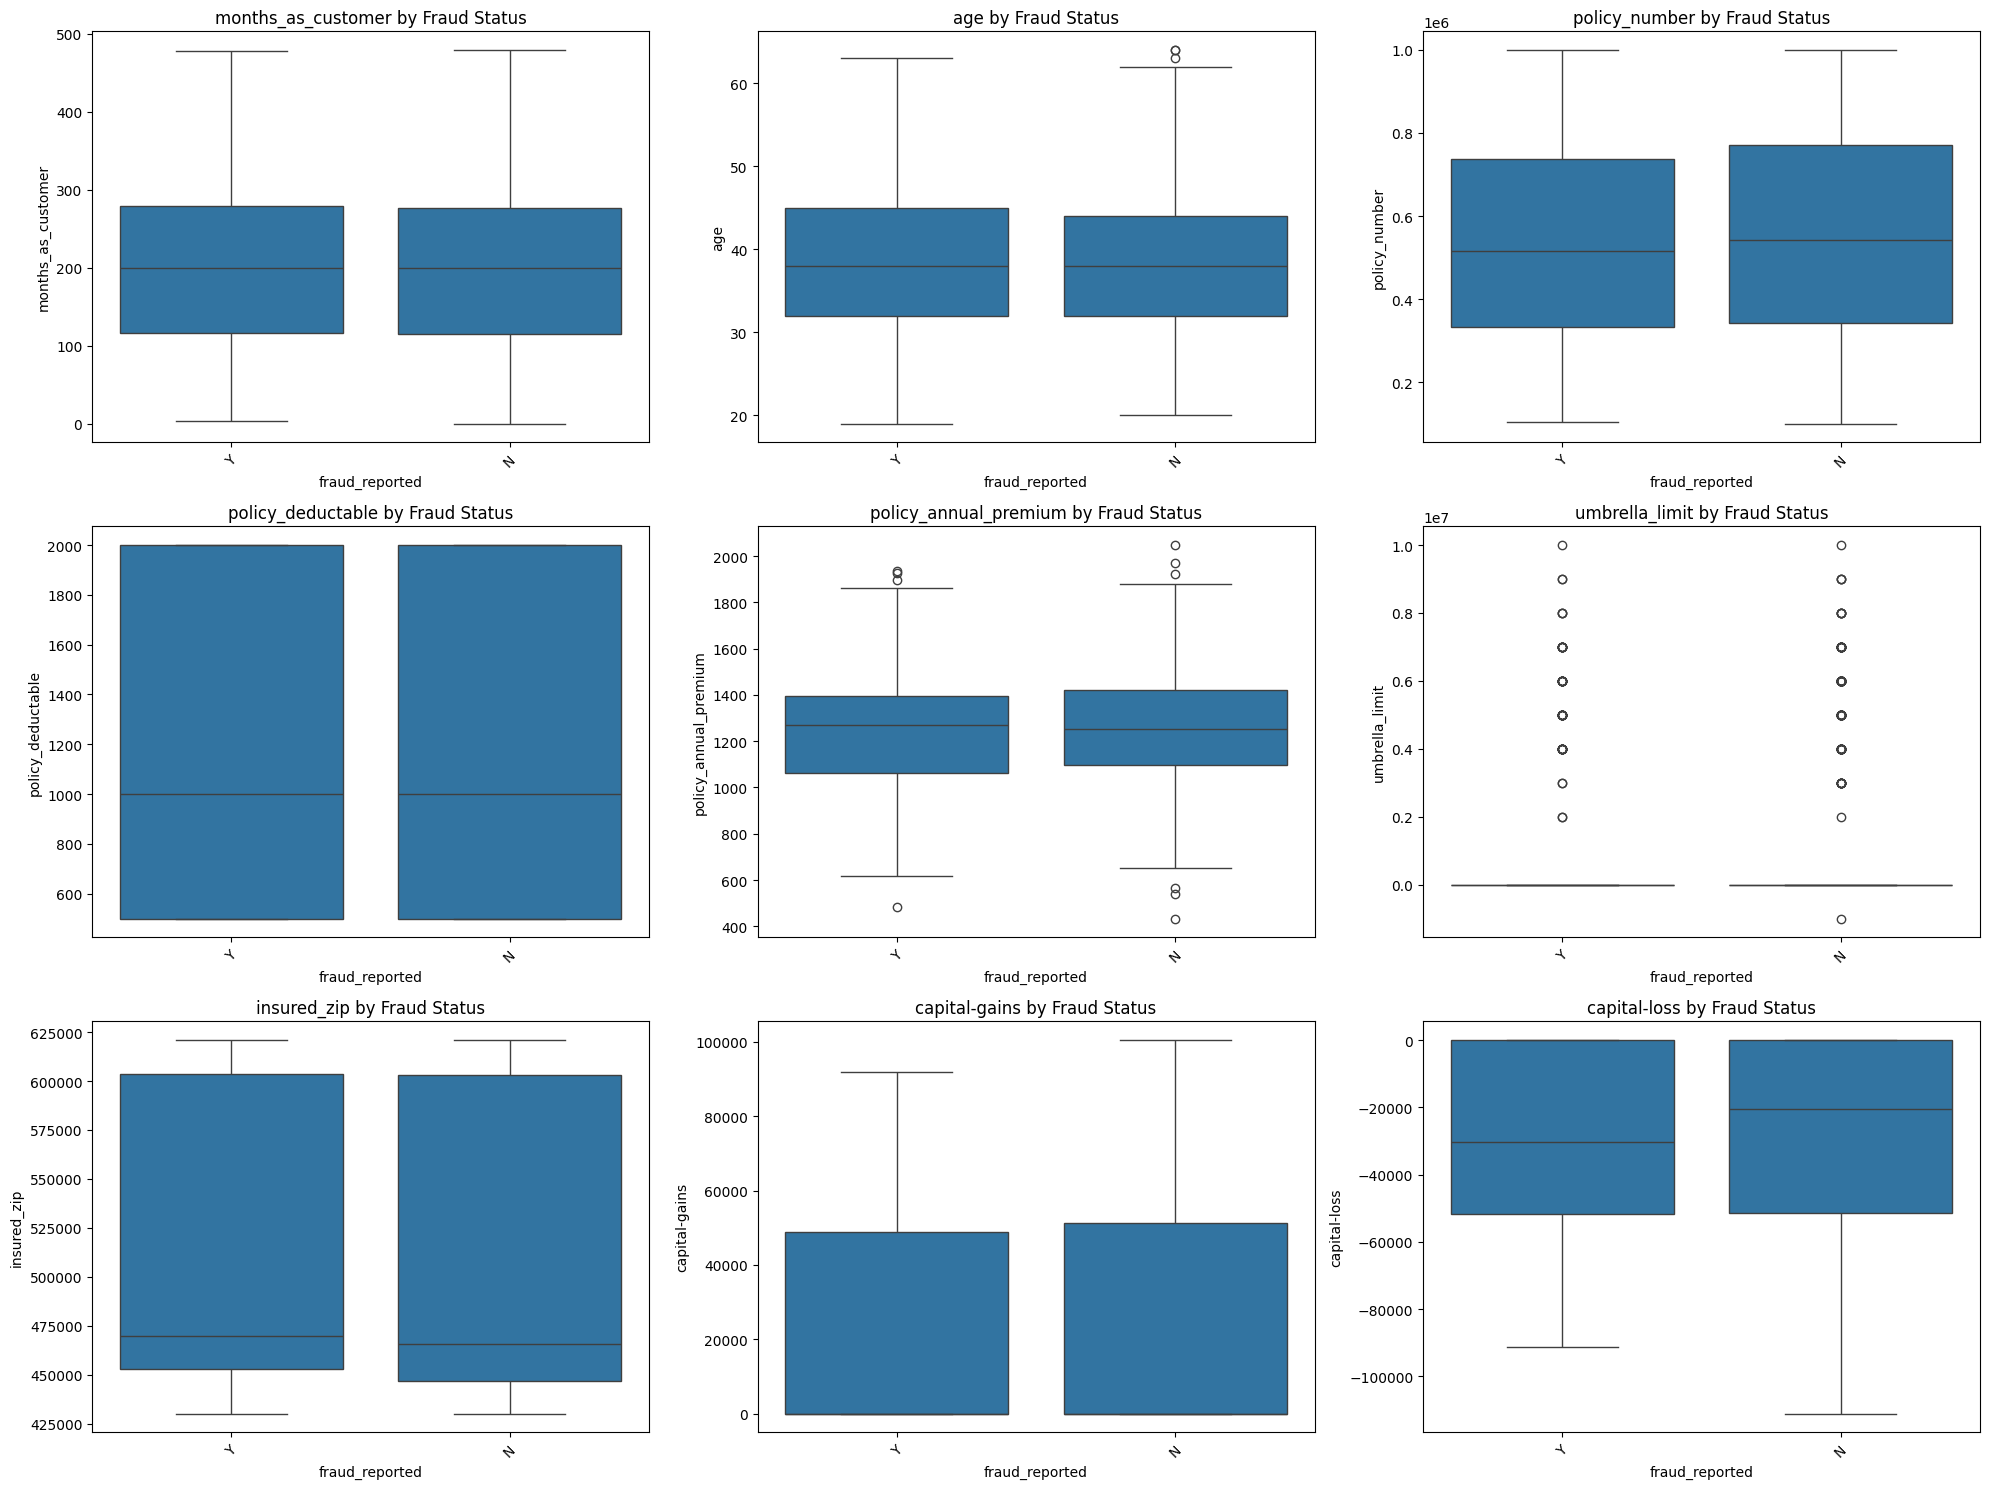

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Select numerical columns and the target column
numerical_cols = [col for col in df.columns if isinstance(df.schema[col].dataType, NumericType)]
target_col = "fraud_reported"

# Convert PySpark DataFrame to Pandas for visualization
pandas_df = df.select(numerical_cols + [target_col]).toPandas()

# Visualize using boxplots
fig, axes = plt.subplots(3, 3, figsize=(20, 15))  # Adjust grid size based on number of numerical columns
axes = axes.ravel()

# Plot up to 9 numerical columns
for idx, col in enumerate(numerical_cols[:9]):
    sns.boxplot(data=pandas_df, x=target_col, y=col, ax=axes[idx])
    axes[idx].set_title(f'{col} by Fraud Status')
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout and display
plt.tight_layout()
plt.show()


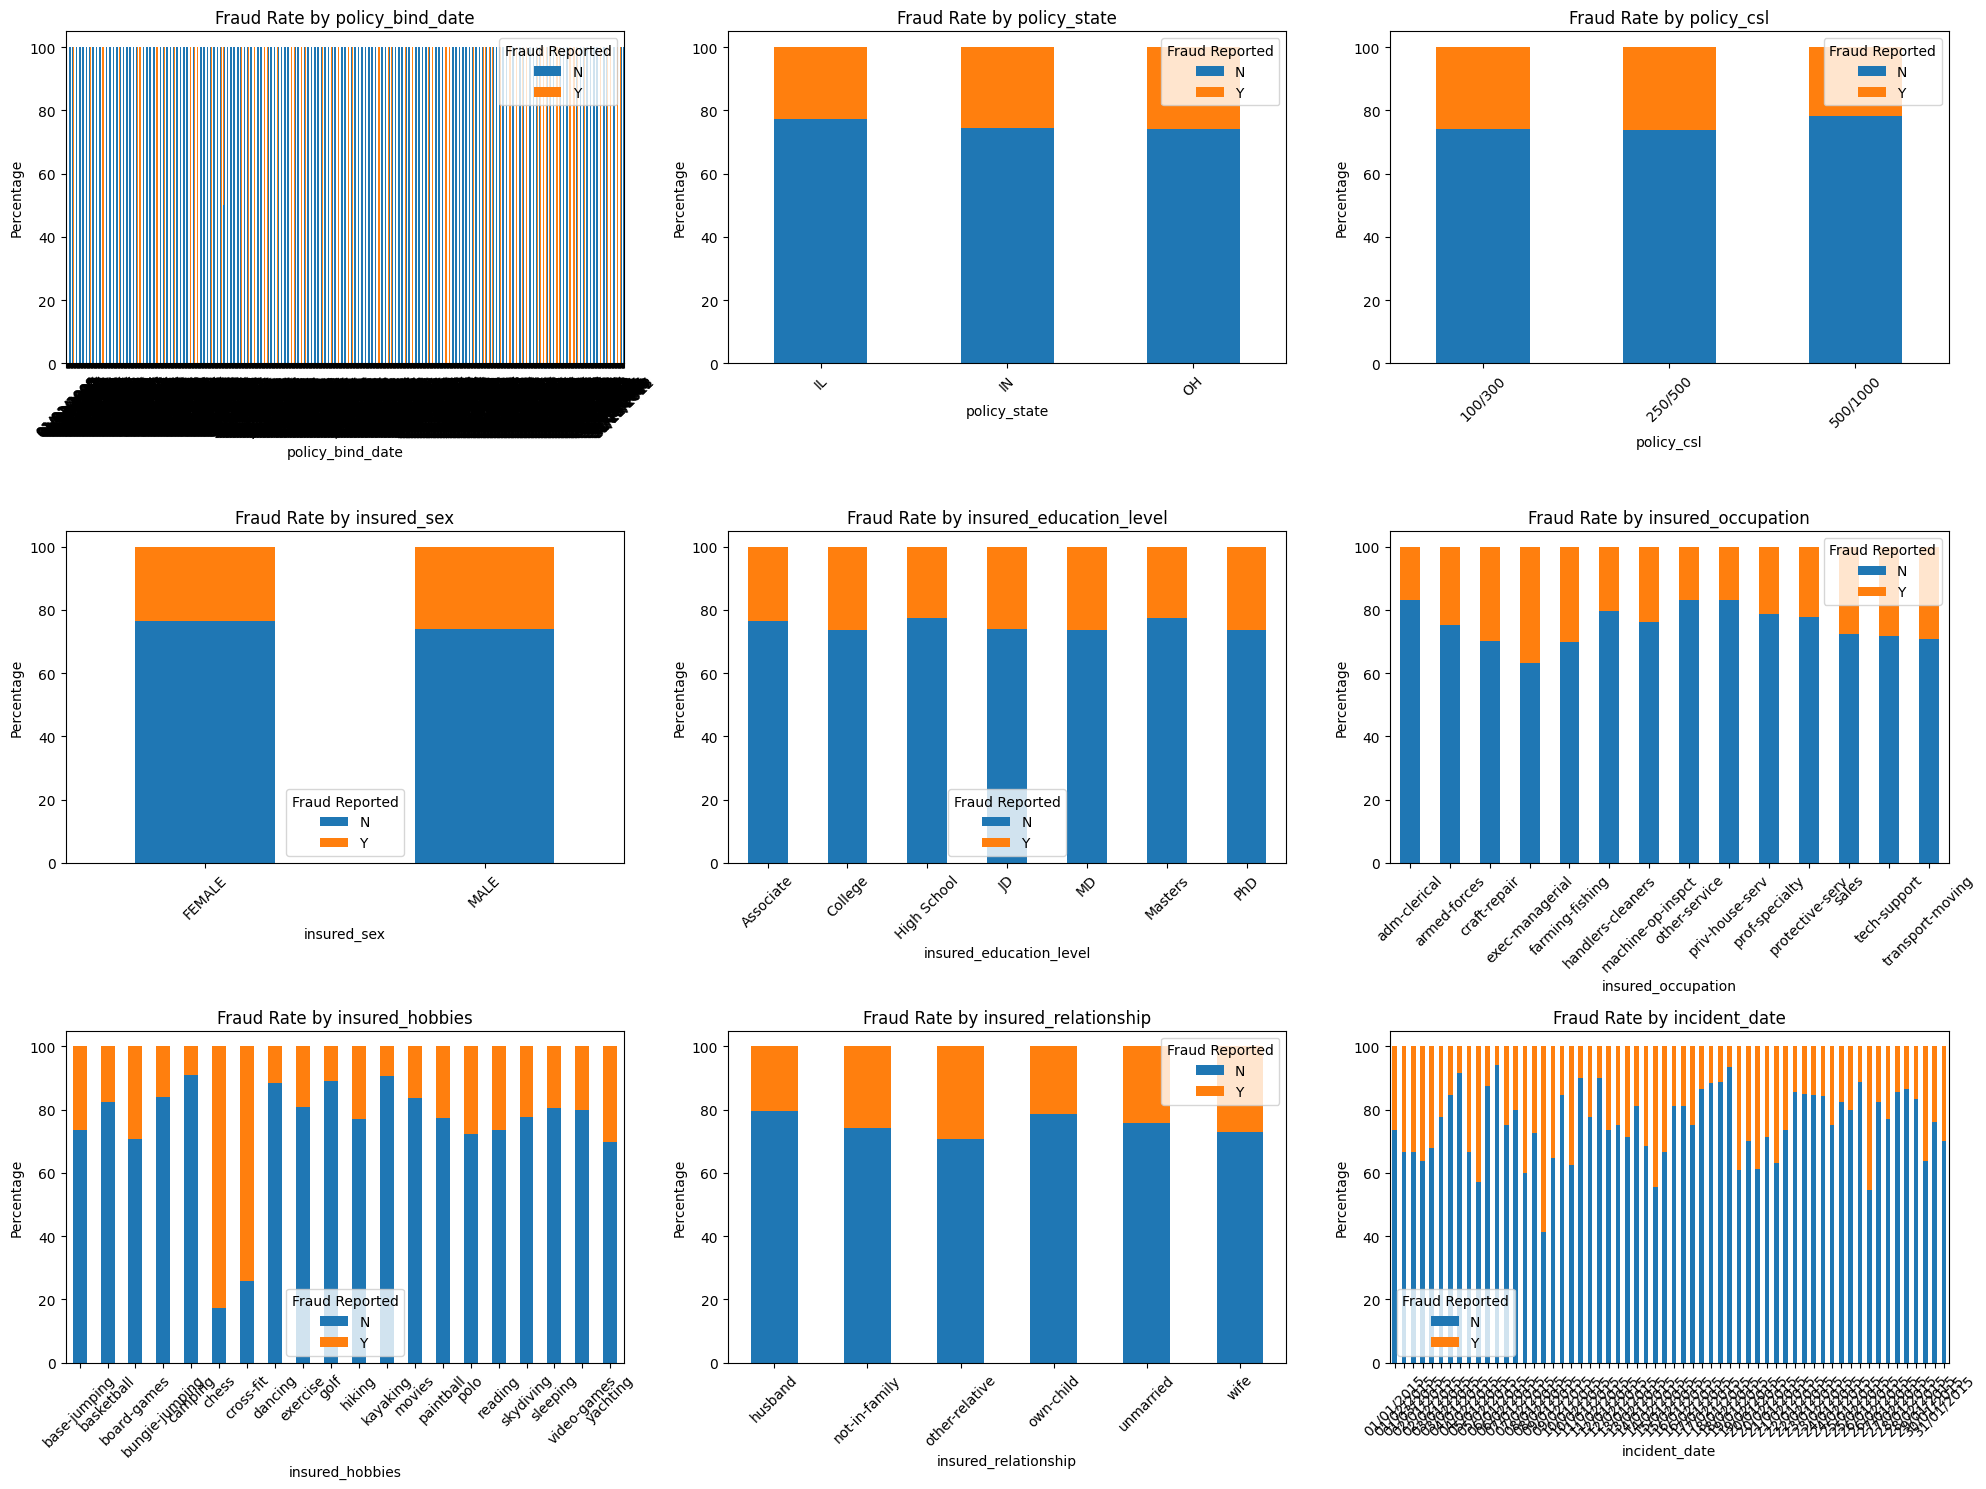

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Target column and categorical columns
target_col = "fraud_reported"

# Ensure categorical_cols list is populated
categorical_cols = [col for col in df.columns if isinstance(df.schema[col].dataType, StringType) and col != target_col]

# Prepare data for visualization
plot_data = []

for col in categorical_cols[:9]:  # Analyze up to 9 categorical columns
    # Calculate percentages
    cat_counts = df.groupBy(col, target_col).count()
    total_counts = df.groupBy(col).count().withColumnRenamed("count", "total")
    
    # Join and calculate percentage
    percentages = cat_counts.join(total_counts, on=col)
    percentages = percentages.withColumn(
        "percentage", (percentages["count"] / percentages["total"]) * 100
    )
    
    # Convert to Pandas for visualization
    percentages_pd = percentages.select(col, target_col, "percentage").toPandas()
    plot_data.append((col, percentages_pd))

# Visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 15))  # Adjust grid size if more columns are to be plotted
axes = axes.ravel()

for idx, (col, percentages_pd) in enumerate(plot_data):
    if idx < len(axes):
        pivot_df = percentages_pd.pivot(index=col, columns=target_col, values="percentage")
        pivot_df.plot(kind="bar", stacked=True, ax=axes[idx])
        axes[idx].set_title(f'Fraud Rate by {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Percentage')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].legend(title='Fraud Reported')

plt.tight_layout()
plt.show()


In [35]:
import plotly.express as px

# Convert relevant columns to Pandas
claim_amount_df = df.select("fraud_reported", "total_claim_amount").toPandas()

# Plot
fig = px.box(
    claim_amount_df, 
    x="fraud_reported", 
    y="total_claim_amount", 
    title="Total Claim Amount Distribution by Fraud Status",
    color="fraud_reported"
)
fig.show()


In [36]:
# Convert relevant columns to Pandas
age_df = df.select("age", "fraud_reported").toPandas()

# Plot
fig = px.histogram(
    age_df, 
    x="age", 
    color="fraud_reported", 
    title="Age Distribution by Fraud Status", 
    marginal="box", 
    nbins=30
)
fig.show()


In [16]:
# Convert relevant columns to Pandas
scatter_df = df.select("auto_year", "total_claim_amount", "age", "fraud_reported").toPandas()

# Plot
fig = px.scatter(
    scatter_df, 
    x="auto_year", 
    y="total_claim_amount", 
    color="fraud_reported", 
    size="age", 
    title="Vehicle Year vs Claim Amount (Sized by Age)"
)
fig.show()


## 4. Data Preprocessing and Feature Engineering

In [37]:
from pyspark.sql.functions import col, when, lit, year
from pyspark.sql.types import DoubleType
import datetime

# Feature Engineering
print("Creating new features...")

# 1. Age groups
df_processed = df.withColumn(
    'age_group',
    when(col('age') <= 25, lit('Young'))
    .when((col('age') > 25) & (col('age') <= 35), lit('Adult'))
    .when((col('age') > 35) & (col('age') <= 50), lit('Middle-aged'))
    .when((col('age') > 50) & (col('age') <= 65), lit('Senior'))
    .otherwise(lit('Elderly'))
)

# 2. Vehicle age
current_year = datetime.datetime.now().year
df_processed = df_processed.withColumn(
    'vehicle_age',
    lit(current_year) - col('auto_year')
)

# 3. Claim amount per vehicle
df_processed = df_processed.withColumn(
    'claim_per_vehicle',
    (col('total_claim_amount') / col('number_of_vehicles_involved')).cast(DoubleType())
)

# 4. Is night incident
df_processed = df_processed.withColumn(
    'is_night_incident',
    (col('incident_hour_of_the_day') >= 22) | (col('incident_hour_of_the_day') <= 6)
)

# 5. High value claim (top 25%)
claim_75th = df_processed.approxQuantile('total_claim_amount', [0.75], 0.01)[0]
df_processed = df_processed.withColumn(
    'high_value_claim',
    col('total_claim_amount') > lit(claim_75th)
)

# 6. Customer tenure groups
df_processed = df_processed.withColumn(
    'tenure_group',
    when(col('months_as_customer') <= 12, lit('New'))
    .when((col('months_as_customer') > 12) & (col('months_as_customer') <= 36), lit('Short-term'))
    .when((col('months_as_customer') > 36) & (col('months_as_customer') <= 60), lit('Medium-term'))
    .otherwise(lit('Long-term'))
)

# 7. Claim severity score
df_processed = df_processed.withColumn(
    'total_claim_ratio',
    ((col('injury_claim') + col('property_claim') + col('vehicle_claim')) / col('total_claim_amount')).cast(DoubleType())
)

print("New features created:")
new_features = [
    'age_group', 'vehicle_age', 'claim_per_vehicle', 'is_night_incident',
    'high_value_claim', 'tenure_group', 'total_claim_ratio'
]
print(new_features)

# Show a few rows to verify
df_processed.select(new_features).show()


Creating new features...
New features created:
['age_group', 'vehicle_age', 'claim_per_vehicle', 'is_night_incident', 'high_value_claim', 'tenure_group', 'total_claim_ratio']
+-----------+-----------+------------------+-----------------+----------------+------------+-----------------+
|  age_group|vehicle_age| claim_per_vehicle|is_night_incident|high_value_claim|tenure_group|total_claim_ratio|
+-----------+-----------+------------------+-----------------+----------------+------------+-----------------+
|Middle-aged|         21|           71610.0|             true|            true|   Long-term|              1.0|
|Middle-aged|         18|            5070.0|            false|           false|   Long-term|              1.0|
|      Adult|         18|           11550.0|            false|           false|   Long-term|              1.0|
|Middle-aged|         11|           63400.0|             true|           false|   Long-term|              1.0|
|Middle-aged|         16|            6500.0|    

In [20]:
from pyspark.ml.feature import StringIndexer

# Identify categorical columns (string/object types)
categorical_features = [
    field.name for field in df_processed.schema.fields if field.dataType.simpleString() == 'string'
]

# Remove target variable from categorical features
if 'fraud_reported' in categorical_features:
    categorical_features.remove('fraud_reported')

print("Encoding categorical variables...")
for col in categorical_features:
    indexer = StringIndexer(inputCol=col, outputCol=col + '_encoded')
    df_processed = indexer.fit(df_processed).transform(df_processed)
    print(f"Encoded {col}")

# Encode target variable
target_indexer = StringIndexer(inputCol='fraud_reported', outputCol='fraud_reported_encoded')
df_processed = target_indexer.fit(df_processed).transform(df_processed)

# Verify encodings
print("Encoded categorical features and target variable:")
df_processed.select(
    [col + '_encoded' for col in categorical_features] + ['fraud_reported_encoded']
).show()


Encoding categorical variables...
Encoded policy_bind_date
Encoded policy_state
Encoded policy_csl
Encoded insured_sex
Encoded insured_education_level
Encoded insured_occupation
Encoded insured_hobbies
Encoded insured_relationship
Encoded incident_date
Encoded incident_type
Encoded collision_type
Encoded incident_severity
Encoded authorities_contacted
Encoded incident_state
Encoded incident_city
Encoded incident_location
Encoded property_damage
Encoded police_report_available
Encoded auto_make
Encoded auto_model
Encoded age_group
Encoded tenure_group
Encoded categorical features and target variable:
+------------------------+--------------------+------------------+-------------------+-------------------------------+--------------------------+-----------------------+----------------------------+---------------------+---------------------+----------------------+-------------------------+-----------------------------+----------------------+---------------------+-------------------------+-

In [40]:
from pyspark.sql.functions import when, col

# Ensure 'fraud_reported_encoded' exists
if "fraud_reported_encoded" not in df_processed.columns:
    df_processed = df_processed.withColumn(
        "fraud_reported_encoded", 
        when(col("fraud_reported") == "Y", 1).otherwise(0)
    )

# Prepare feature matrix and target vector
X = df_processed.select(*feature_columns)
y = df_processed.select("fraud_reported_encoded")

print(f"Feature matrix shape: ({X.count()}, {len(X.columns)})")
print(f"Target vector shape: ({y.count()}, 1)")


Feature matrix shape: (1000, 23)
Target vector shape: (1000, 1)


## 5. Feature Selection and Scaling

In [45]:
from sklearn.ensemble import RandomForestClassifier


In [48]:
import pandas as pd
import numpy as np
from pyspark.sql import DataFrame as SparkDataFrame

# Debug types and contents
print("Type of X:", type(X))
print("Type of y:", type(y))

# Display first 5 rows
if isinstance(X, SparkDataFrame):
    print("X head (PySpark DataFrame):")
    X.show(5, truncate=False)
elif isinstance(X, pd.DataFrame):
    print("X head (Pandas DataFrame):\n", X.head())
else:
    print("X head (array-like):\n", X[:5])

if isinstance(y, SparkDataFrame):
    print("y head (PySpark DataFrame):")
    y.show(5, truncate=False)
elif isinstance(y, pd.Series):
    print("y head (Pandas Series):\n", y.head())
else:
    print("y head (array-like):\n", y[:5])

# Display dtypes
if isinstance(X, SparkDataFrame):
    print("X dtypes (PySpark schema):")
    X.printSchema()
elif isinstance(X, pd.DataFrame):
    print("X dtypes (Pandas):\n", X.dtypes)
else:
    print("X dtype (array):\n", np.array(X).dtype)

Type of X: <class 'pyspark.sql.classic.dataframe.DataFrame'>
Type of y: <class 'pyspark.sql.classic.dataframe.DataFrame'>
X head (PySpark DataFrame):
+------------------+---+-------------+-----------------+---------------------+--------------+-----------+-------------+------------+------------------------+---------------------------+---------------+---------+------------------+------------+--------------+-------------+---------+-----------+-----------------+-----------------+-----------------+----------------+
|months_as_customer|age|policy_number|policy_deductable|policy_annual_premium|umbrella_limit|insured_zip|capital-gains|capital-loss|incident_hour_of_the_day|number_of_vehicles_involved|bodily_injuries|witnesses|total_claim_amount|injury_claim|property_claim|vehicle_claim|auto_year|vehicle_age|claim_per_vehicle|total_claim_ratio|is_night_incident|high_value_claim|
+------------------+---+-------------+-----------------+---------------------+--------------+-----------+-------------

In [50]:
import pandas as pd
import numpy as np

# Convert X to Pandas
X_pandas = X.toPandas()

# Convert y to Pandas and extract the target column
y_pandas = y.toPandas()['fraud_reported_encoded']

# Verify shapes and types
print("X_pandas shape:", X_pandas.shape)
print("y_pandas shape:", y_pandas.shape)
print("X_pandas dtypes:\n", X_pandas.dtypes)
print("y_pandas dtype:", y_pandas.dtype)

X_pandas shape: (1000, 23)
y_pandas shape: (1000,)
X_pandas dtypes:
 months_as_customer               int32
age                              int32
policy_number                    int32
policy_deductable                int32
policy_annual_premium          float64
umbrella_limit                   int32
insured_zip                      int32
capital-gains                    int32
capital-loss                     int32
incident_hour_of_the_day         int32
number_of_vehicles_involved      int32
bodily_injuries                  int32
witnesses                        int32
total_claim_amount               int32
injury_claim                     int32
property_claim                   int32
vehicle_claim                    int32
auto_year                        int32
vehicle_age                      int32
claim_per_vehicle              float64
total_claim_ratio              float64
is_night_incident                 bool
high_value_claim                  bool
dtype: object
y_pandas dtype: int3

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit the model
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_balanced, y_balanced)

print("Model fitted successfully!")

Model fitted successfully!


In [53]:
from sklearn.feature_selection import SelectFromModel

# Feature importances
feature_importances = pd.DataFrame({
    'feature': X_pandas.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances:\n", feature_importances.head(10))

# Optional: Select important features
selector = SelectFromModel(rf_selector, threshold='median')
X_selected = selector.fit_transform(X_balanced, y_balanced)
selected_features = X_pandas.columns[selector.get_support()].tolist()
print("\nSelected Features:", selected_features)


Top 10 Feature Importances:
                   feature  importance
6             insured_zip    0.072812
16          vehicle_claim    0.069320
12              witnesses    0.065486
15         property_claim    0.064169
13     total_claim_amount    0.063883
14           injury_claim    0.056821
2           policy_number    0.056137
19      claim_per_vehicle    0.055539
4   policy_annual_premium    0.051482
0      months_as_customer    0.051220

Selected Features: ['months_as_customer', 'age', 'policy_number', 'policy_annual_premium', 'insured_zip', 'incident_hour_of_the_day', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'claim_per_vehicle']


In [54]:
import pandas as pd
import numpy as np

# Convert X to Pandas
X_pandas = X.toPandas()

# Convert y to Pandas and extract the target column
y_pandas = y.toPandas()['fraud_reported_encoded']

# Verify shapes and types
print("X_pandas shape:", X_pandas.shape)
print("y_pandas shape:", y_pandas.shape)
print("X_pandas dtypes:\n", X_pandas.dtypes)
print("y_pandas dtype:", y_pandas.dtype)

X_pandas shape: (1000, 23)
y_pandas shape: (1000,)
X_pandas dtypes:
 months_as_customer               int32
age                              int32
policy_number                    int32
policy_deductable                int32
policy_annual_premium          float64
umbrella_limit                   int32
insured_zip                      int32
capital-gains                    int32
capital-loss                     int32
incident_hour_of_the_day         int32
number_of_vehicles_involved      int32
bodily_injuries                  int32
witnesses                        int32
total_claim_amount               int32
injury_claim                     int32
property_claim                   int32
vehicle_claim                    int32
auto_year                        int32
vehicle_age                      int32
claim_per_vehicle              float64
total_claim_ratio              float64
is_night_incident                 bool
high_value_claim                  bool
dtype: object
y_pandas dtype: int3

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Convert boolean columns to integers
boolean_cols = ['is_night_incident', 'high_value_claim']
X_pandas[boolean_cols] = X_pandas[boolean_cols].astype(int)

# Check for missing values
print("Missing values in X_pandas:\n", X_pandas.isnull().sum())

# Impute missing values (if any)
numerical_cols = X_pandas.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
imputer = SimpleImputer(strategy='mean')
X_pandas[numerical_cols] = imputer.fit_transform(X_pandas[numerical_cols])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pandas)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y_pandas)

# Verify shapes after SMOTE
print("X_balanced shape:", X_balanced.shape)
print("y_balanced shape:", y_balanced.shape)
print("X_balanced dtype:", X_balanced.dtype)
print("y_balanced dtype:", y_balanced.dtype)

Missing values in X_pandas:
 months_as_customer             0
age                            0
policy_number                  0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
capital-gains                  0
capital-loss                   0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
bodily_injuries                0
witnesses                      0
total_claim_amount             0
injury_claim                   0
property_claim                 0
vehicle_claim                  0
auto_year                      0
vehicle_age                    0
claim_per_vehicle              0
total_claim_ratio              0
is_night_incident              0
high_value_claim               0
dtype: int64
X_balanced shape: (1506, 23)
y_balanced shape: (1506,)
X_balanced dtype: float64
y_balanced dtype: int32


In [56]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Select top 20 features
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X_balanced, y_balanced)

# Get selected feature names
selected_features = X_pandas.columns[selector.get_support()].tolist()

print(f"Selected {len(selected_features)} features:")
print(selected_features)

# Convert X_selected to Pandas DataFrame
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

# Verify shapes
print("X_selected_df shape:", X_selected_df.shape)

Selected 20 features:
['months_as_customer', 'age', 'policy_deductable', 'umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year', 'vehicle_age', 'claim_per_vehicle', 'is_night_incident', 'high_value_claim']
X_selected_df shape: (1506, 20)


In [58]:
from sklearn.model_selection import train_test_split

# Update X with selected features
X = X_selected_df

# Split the data (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Testing target distribution: {np.bincount(y_test)}")

Training set shape: (1204, 20)
Testing set shape: (302, 20)
Training target distribution: [602 602]
Testing target distribution: [151 151]


In [59]:
# Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using RobustScaler")
print(f"Training data scaled shape: {X_train_scaled.shape}")
print(f"Testing data scaled shape: {X_test_scaled.shape}")

Features scaled using RobustScaler
Training data scaled shape: (1204, 20)
Testing data scaled shape: (302, 20)


## 6. Handle Class Imbalance

In [60]:
# Check class distribution
print("Original class distribution:")
print(f"Class 0 (No Fraud): {np.sum(y_train == 0)}")
print(f"Class 1 (Fraud): {np.sum(y_train == 1)}")

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE balancing:")
print(f"Class 0 (No Fraud): {np.sum(y_train_balanced == 0)}")
print(f"Class 1 (Fraud): {np.sum(y_train_balanced == 1)}")
print(f"Balanced training set shape: {X_train_balanced.shape}")

Original class distribution:
Class 0 (No Fraud): 602
Class 1 (Fraud): 602

After SMOTE balancing:
Class 0 (No Fraud): 602
Class 1 (Fraud): 602
Balanced training set shape: (1204, 20)


## 7. Model Training and Comparison

In [93]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import joblib
import pandas as pd
from datetime import datetime

# Start MLflow experiment
mlflow.set_experiment("Insurance_Fraud_Detection")

# Train and evaluate models with MLflow tracking
model_results = {}
trained_models = {}

for name, model in models.items():
    with mlflow.start_run(run_name=f"{name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
        print(f"\nTraining {name}...")
        
        # Log model parameters
        mlflow.log_param("model_name", name)
        if name in param_grids:
            mlflow.log_params(model.get_params())
        
        # Train the model
        model.fit(X_train_balanced, y_train_balanced)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        
        # Store results
        model_results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'Predictions': y_pred,
            'Probabilities': y_pred_proba
        }
        trained_models[name] = model
        
        # Log model
        mlflow.sklearn.log_model(model, f"{name}_model")

# Create comparison dataframe
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

# Log comparison table as artifact
comparison_df.to_csv("model_comparison.csv")
mlflow.log_artifact("model_comparison.csv")

# Find the best model
best_model_name = comparison_df.index[0]
best_model = trained_models[best_model_name]

# Hyperparameter tuning for the best model
if best_model_name in param_grids:
    with mlflow.start_run(run_name=f"{best_model_name}_GridSearch_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
        print(f"Optimizing {best_model_name} with GridSearchCV...")
        
        # Log parameters
        mlflow.log_param("model_name", best_model_name)
        mlflow.log_params(param_grids[best_model_name])
        
        # Perform grid search
        grid_search = GridSearchCV(
            estimator=type(best_model)(**best_model.get_params()),
            param_grid=param_grids[best_model_name],
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train_balanced, y_train_balanced)
        
        # Log best parameters and score
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("best_cv_f1_score", grid_search.best_score_)
        
        # Update best model with optimized parameters
        best_model_optimized = grid_search.best_estimator_
        
        # Log optimized model
        mlflow.sklearn.log_model(best_model_optimized, f"{best_model_name}_optimized")
        
        # Cross-validation scores
        cv_scores = cross_val_score(best_model_optimized, X_train_balanced, y_train_balanced, 
                                  cv=5, scoring='f1')
        
        # Log CV scores
        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std() * 2)
        
        # Final evaluation on test set
        final_predictions = best_model_optimized.predict(X_test_scaled)
        final_probabilities = best_model_optimized.predict_proba(X_test_scaled)[:, 1]
        
        final_metrics = {
            'Accuracy': accuracy_score(y_test, final_predictions),
            'Precision': precision_score(y_test, final_predictions),
            'Recall': recall_score(y_test, final_predictions),
            'F1-Score': f1_score(y_test, final_predictions),
            'ROC-AUC': roc_auc_score(y_test, final_probabilities)
        }
        
        # Log final metrics
        for metric, score in final_metrics.items():
            mlflow.log_metric(f"final_{metric.lower()}", score)

        # Save model artifacts
        model_artifacts = {
            'model': best_model_optimized,
            'scaler': scaler,
            'feature_selector': selector,
            'label_encoders': label_encoders,
            'target_encoder': target_encoder,
            'selected_features': list(selected_features),
            'feature_columns': feature_columns,
            'model_name': best_model_name,
            'performance_metrics': final_metrics
        }
        
        joblib.dump(model_artifacts, 'fraud_detection_model.pkl')
        mlflow.log_artifact('fraud_detection_model.pkl')
        
        # Save model summary
        summary = f"""
        INSURANCE FRAUD DETECTION MODEL SUMMARY
        ======================================
        
        Best Model: {best_model_name}
        Training Data Size: {X_train.shape[0]} samples
        Test Data Size: {X_test.shape[0]} samples
        Number of Features: {len(selected_features)}
        
        Performance Metrics:
        - Accuracy: {final_metrics['Accuracy']:.4f}
        - Precision: {final_metrics['Precision']:.4f}
        - Recall: {final_metrics['Recall']:.4f}
        - F1-Score: {final_metrics['F1-Score']:.4f}
        - ROC-AUC: {final_metrics['ROC-AUC']:.4f}
        
        Cross-Validation F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})
        
        Selected Features:
        {chr(10).join([f'- {feature}' for feature in selected_features])}
        
        Model saved as: fraud_detection_model.pkl
        """
        
        with open('model_summary.txt', 'w') as f:
            f.write(summary)
        mlflow.log_artifact('model_summary.txt')


Training Logistic Regression...


2025/06/17 21:50:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training Random Forest...


2025/06/17 21:50:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training Gradient Boosting...


2025/06/17 21:50:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training XGBoost...


2025/06/17 21:50:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training LightGBM...


2025/06/17 21:50:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Noor\AppData\Local\Temp\tmppomhdfgx\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/06/17 21:50:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training SVM...


2025/06/17 21:50:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training Naive Bayes...


2025/06/17 21:50:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training Decision Tree...


2025/06/17 21:50:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training K-Nearest Neighbors...


2025/06/17 21:50:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training AdaBoost...


2025/06/17 21:51:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [82]:
# Define models (Cell [61])
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

In [83]:
# Train and evaluate models
model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }
    
    trained_models[name] = model
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

print("\nAll models trained successfully!")


Training Logistic Regression...
Logistic Regression - Accuracy: 0.5430, F1: 0.5868, ROC-AUC: 0.5807

Training Random Forest...
Random Forest - Accuracy: 0.7881, F1: 0.7793, ROC-AUC: 0.8919

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.7715, F1: 0.7612, ROC-AUC: 0.8588

Training XGBoost...
XGBoost - Accuracy: 0.7947, F1: 0.7877, ROC-AUC: 0.8761

Training LightGBM...
LightGBM - Accuracy: 0.8079, F1: 0.7958, ROC-AUC: 0.8826

Training SVM...
SVM - Accuracy: 0.7219, F1: 0.7439, ROC-AUC: 0.8070

Training Naive Bayes...
Naive Bayes - Accuracy: 0.5596, F1: 0.6491, ROC-AUC: 0.5486

Training Decision Tree...
Decision Tree - Accuracy: 0.6921, F1: 0.7121, ROC-AUC: 0.6921

Training K-Nearest Neighbors...
K-Nearest Neighbors - Accuracy: 0.6391, F1: 0.7078, ROC-AUC: 0.7654

Training AdaBoost...
AdaBoost - Accuracy: 0.6987, F1: 0.7093, ROC-AUC: 0.7830

All models trained successfully!


In [84]:
# Create comparison dataframe
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("Model Performance Comparison:")
print(comparison_df.round(4))

# Find the best model
best_model_name = comparison_df.index[0]
best_model = trained_models[best_model_name]
print(f"\n🏆 Best performing model: {best_model_name}")
print(f"Best F1-Score: {comparison_df.loc[best_model_name, 'F1-Score']:.4f}")

Model Performance Comparison:
                     Accuracy Precision    Recall  F1-Score   ROC-AUC
LightGBM             0.807947  0.849624  0.748344  0.795775  0.882593
XGBoost              0.794702  0.815603  0.761589  0.787671  0.876102
Random Forest        0.788079   0.81295  0.748344   0.77931  0.891891
Gradient Boosting    0.771523  0.797101  0.728477  0.761246  0.858822
SVM                  0.721854  0.689266  0.807947  0.743902  0.806982
Decision Tree        0.692053  0.668605  0.761589  0.712074  0.692053
AdaBoost             0.698675  0.685185  0.735099  0.709265   0.78297
K-Nearest Neighbors  0.639073  0.594595  0.874172  0.707775  0.765383
Naive Bayes          0.559603  0.539474   0.81457  0.649077  0.548616
Logistic Regression  0.543046  0.535519  0.649007  0.586826   0.58072

🏆 Best performing model: LightGBM
Best F1-Score: 0.7958


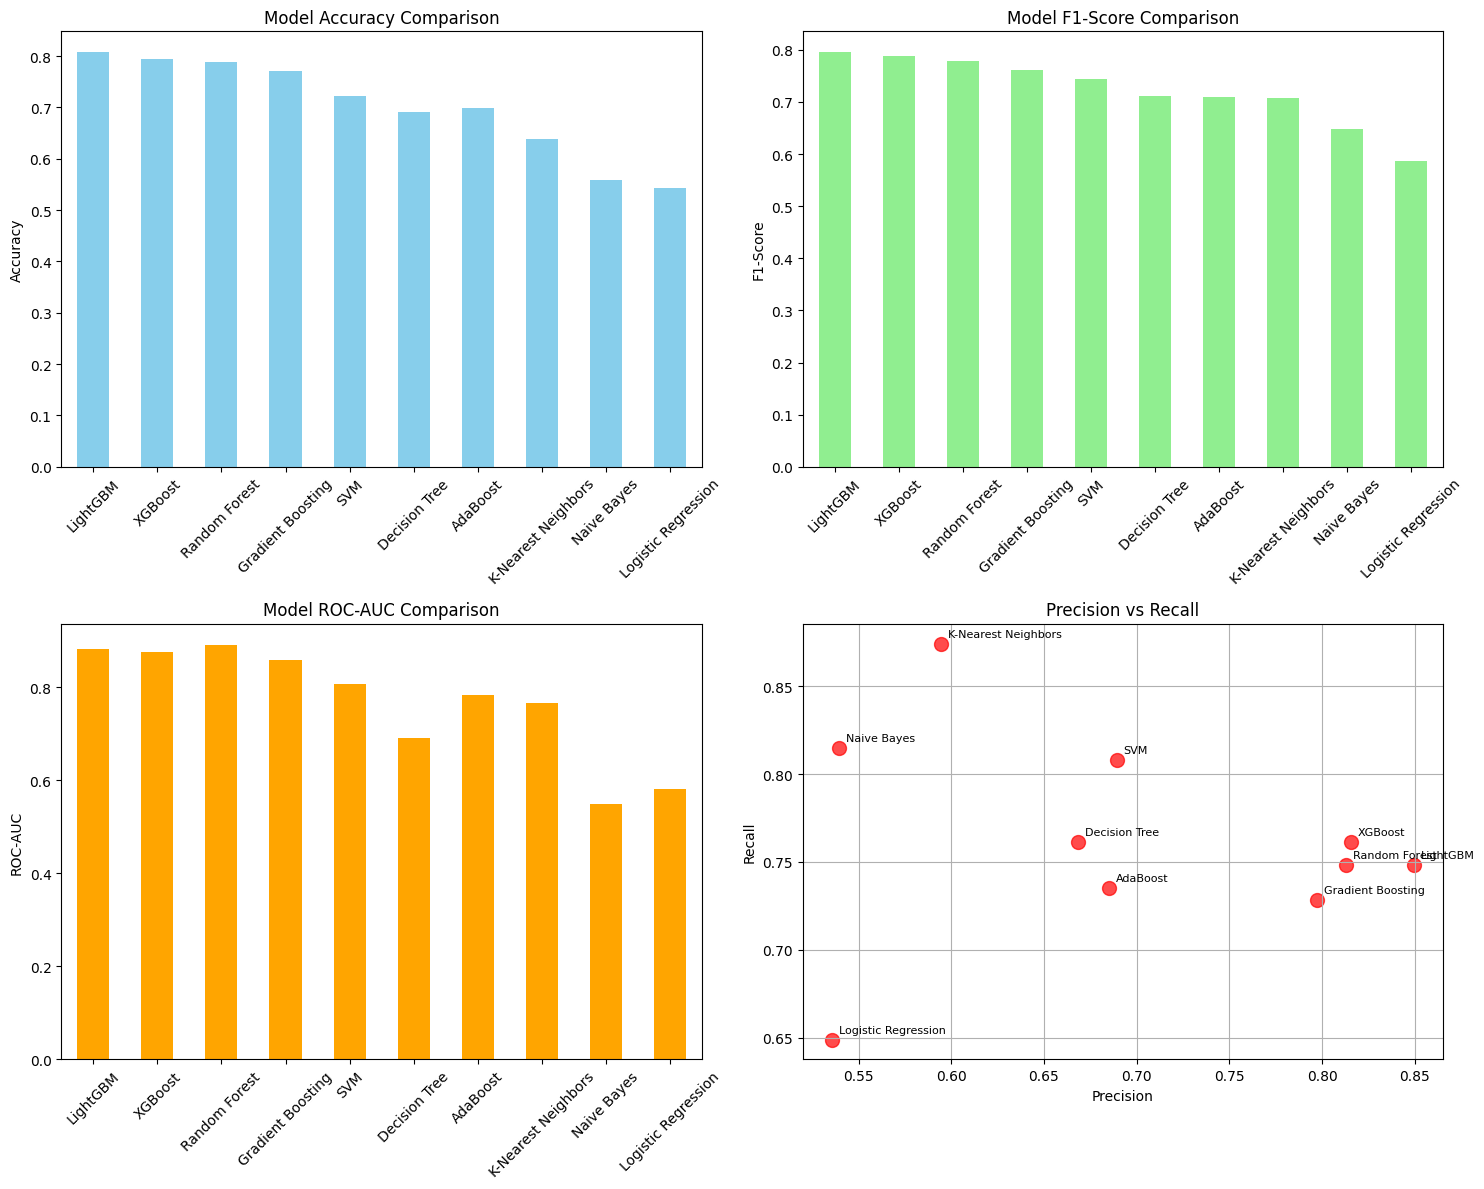

In [85]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
comparison_df['Accuracy'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Model Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)

# F1-Score comparison
comparison_df['F1-Score'].plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Model F1-Score Comparison')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].tick_params(axis='x', rotation=45)

# ROC-AUC comparison
comparison_df['ROC-AUC'].plot(kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Model ROC-AUC Comparison')
axes[1,0].set_ylabel('ROC-AUC')
axes[1,0].tick_params(axis='x', rotation=45)

# Precision vs Recall scatter plot
axes[1,1].scatter(comparison_df['Precision'], comparison_df['Recall'], 
                  s=100, alpha=0.7, c='red')
for i, model in enumerate(comparison_df.index):
    axes[1,1].annotate(model, (comparison_df['Precision'].iloc[i], 
                               comparison_df['Recall'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1,1].set_xlabel('Precision')
axes[1,1].set_ylabel('Recall')
axes[1,1].set_title('Precision vs Recall')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

## 8. Detailed Analysis of Best Model

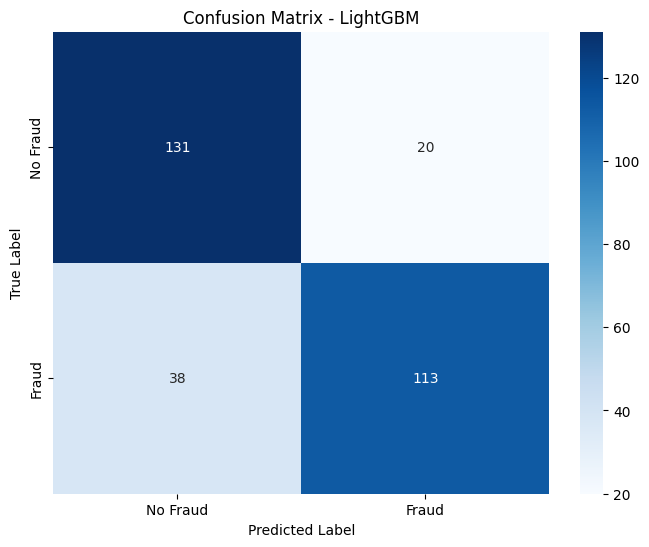


Classification Report for LightGBM:
              precision    recall  f1-score   support

    No Fraud       0.78      0.87      0.82       151
       Fraud       0.85      0.75      0.80       151

    accuracy                           0.81       302
   macro avg       0.81      0.81      0.81       302
weighted avg       0.81      0.81      0.81       302



In [86]:
# Detailed evaluation of the best model
best_predictions = model_results[best_model_name]['Predictions']
best_probabilities = model_results[best_model_name]['Probabilities']

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraud', 'Fraud'], 
            yticklabels=['No Fraud', 'Fraud'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y_test, best_predictions, 
                          target_names=['No Fraud', 'Fraud']))

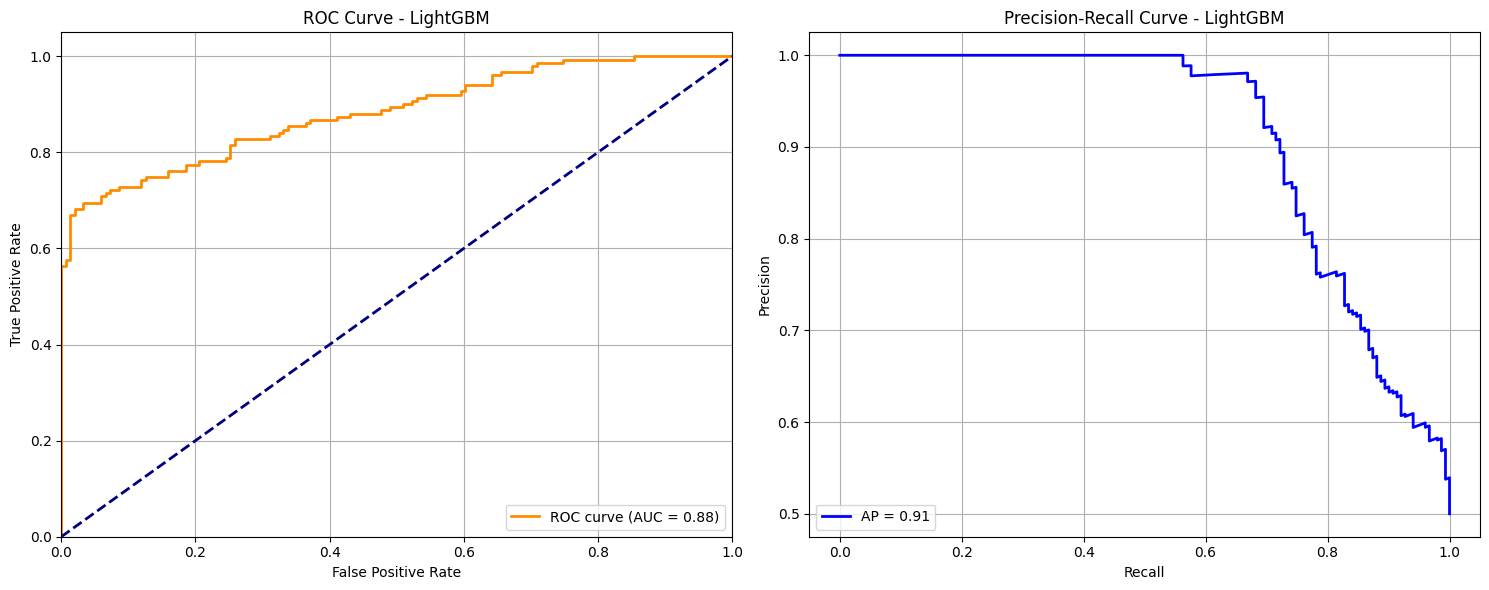

In [87]:
# ROC Curve and Precision-Recall Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_probabilities)
roc_auc = roc_auc_score(y_test, best_probabilities)

ax1.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'ROC Curve - {best_model_name}')
ax1.legend(loc="lower right")
ax1.grid(True)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, best_probabilities)
avg_precision = average_precision_score(y_test, best_probabilities)

ax2.plot(recall_curve, precision_curve, color='blue', lw=2,
         label=f'AP = {avg_precision:.2f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title(f'Precision-Recall Curve - {best_model_name}')
ax2.legend(loc="lower left")
ax2.grid(True)

plt.tight_layout()
plt.show()

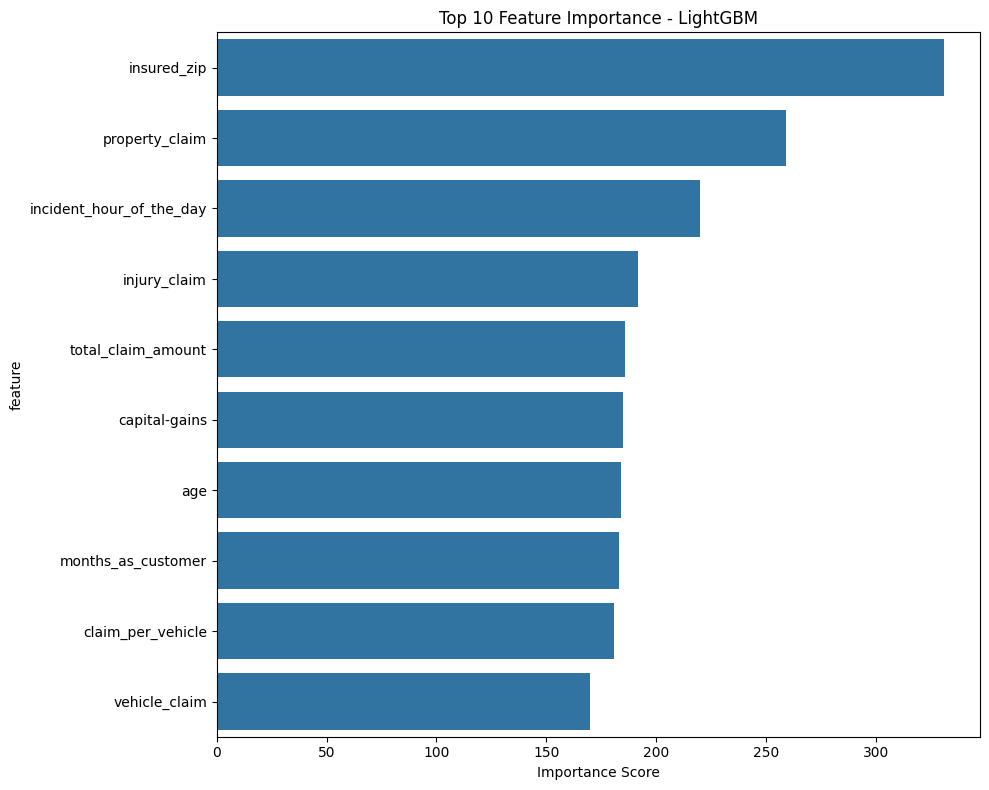

Top 10 most important features:
                     feature  importance
4                insured_zip         331
13            property_claim         259
7   incident_hour_of_the_day         220
12              injury_claim         192
11        total_claim_amount         186
5              capital-gains         185
1                        age         184
0         months_as_customer         183
17         claim_per_vehicle         181
14             vehicle_claim         170


In [88]:
# Feature importance for the best model 
if hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_imp.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features:")
    print(feature_imp.head(10))
else:
    print(f"{best_model_name} does not provide feature importance.")

## 9. Model Optimization and Cross-Validation

In [89]:
# Hyperparameter tuning for the best model
print(f"Optimizing {best_model_name} with GridSearchCV...")

# Define parameter grids for different models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
}

if best_model_name in param_grids:
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=type(best_model)(**best_model.get_params()),
        param_grid=param_grids[best_model_name],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")
    
    # Update best model with optimized parameters
    best_model_optimized = grid_search.best_estimator_
else:
    print(f"No parameter grid defined for {best_model_name}. Using default parameters.")
    best_model_optimized = best_model

Optimizing LightGBM with GridSearchCV...
No parameter grid defined for LightGBM. Using default parameters.


In [90]:
# Cross-validation scores
cv_scores = cross_val_score(best_model_optimized, X_train_balanced, y_train_balanced, 
                           cv=5, scoring='f1')

print(f"\nCross-validation F1-scores: {cv_scores}")
print(f"Mean CV F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Final evaluation on test set
final_predictions = best_model_optimized.predict(X_test_scaled)
final_probabilities = best_model_optimized.predict_proba(X_test_scaled)[:, 1]

final_metrics = {
    'Accuracy': accuracy_score(y_test, final_predictions),
    'Precision': precision_score(y_test, final_predictions),
    'Recall': recall_score(y_test, final_predictions),
    'F1-Score': f1_score(y_test, final_predictions),
    'ROC-AUC': roc_auc_score(y_test, final_probabilities)
}

print(f"\nFinal optimized model performance:")
for metric, score in final_metrics.items():
    print(f"{metric}: {score:.4f}")


Cross-validation F1-scores: [0.82700422 0.81512605 0.80519481 0.79310345 0.83898305]
Mean CV F1-score: 0.8159 (+/- 0.0321)

Final optimized model performance:
Accuracy: 0.8079
Precision: 0.8496
Recall: 0.7483
F1-Score: 0.7958
ROC-AUC: 0.8826


## 10. Model Saving and Deployment Preparation

In [91]:
import mlflow
import mlflow.sklearn

In [92]:
# Save the best model and preprocessing components
model_artifacts = {
    'model': best_model_optimized,
    'scaler': scaler,
    'feature_selector': selector,
    'label_encoders': label_encoders,
    'target_encoder': target_encoder,
    'selected_features': list(selected_features),
    'feature_columns': feature_columns,
    'model_name': best_model_name,
    'performance_metrics': final_metrics
}

# Save the model
joblib.dump(model_artifacts, 'fraud_detection_model.pkl')
print("✅ Model and preprocessing components saved successfully!")

# Save model summary
summary = f"""
INSURANCE FRAUD DETECTION MODEL SUMMARY
======================================

Best Model: {best_model_name}
Training Data Size: {X_train.shape[0]} samples
Test Data Size: {X_test.shape[0]} samples
Number of Features: {len(selected_features)}

Performance Metrics:
- Accuracy: {final_metrics['Accuracy']:.4f}
- Precision: {final_metrics['Precision']:.4f}
- Recall: {final_metrics['Recall']:.4f}
- F1-Score: {final_metrics['F1-Score']:.4f}
- ROC-AUC: {final_metrics['ROC-AUC']:.4f}

Cross-Validation F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})

Selected Features:
{chr(10).join([f'- {feature}' for feature in selected_features])}

Model saved as: fraud_detection_model.pkl
"""

with open('model_summary.txt', 'w') as f:
    f.write(summary)

print(summary)

NameError: name 'target_encoder' is not defined

## 11. Model Testing and Validation

In [ ]:
# Test the saved model
print("Testing the saved model...")
loaded_artifacts = joblib.load('fraud_detection_model.pkl')

# Extract components
loaded_model = loaded_artifacts['model']
loaded_scaler = loaded_artifacts['scaler']
loaded_feature_columns = loaded_artifacts['feature_columns']
loaded_selected_features = loaded_artifacts['selected_features']

# Test prediction on a few samples
test_samples = X_test.iloc[:5]
test_targets = y_test.iloc[:5]

print(f"\nTest sample features: {list(test_samples.columns)}")
print(f"Model selected features: {loaded_selected_features}")

try:
    print("\nUsing the feature selector for prediction...")
    
    # Extract the feature selector
    loaded_selector = loaded_artifacts['feature_selector']
    
    if set(test_samples.columns) == set(loaded_selected_features):
        test_samples_ordered = test_samples[loaded_selected_features]
        test_scaled = loaded_scaler.transform(test_samples_ordered)
        test_predictions = loaded_model.predict(test_scaled)
        test_probabilities = loaded_model.predict_proba(test_scaled)[:, 1]
    else:
        raise ValueError("Feature sets don't match")
        
except Exception as e:
    print(f"Error with first approach: {str(e)}")
    print("\nWARNING: Feature mismatch detected. Using manual approach with available features.")
    
    available_features = [f for f in loaded_selected_features if f in test_samples.columns]
    print(f"Available features: {len(available_features)}/{len(loaded_selected_features)}")
    
    if len(available_features) < len(loaded_selected_features):
        print("Missing features:", set(loaded_selected_features) - set(test_samples.columns))
    
    test_samples_available = test_samples[available_features]
    
    test_scaled = loaded_scaler.transform(test_samples_available)
    
    # Make predictions
    test_predictions = loaded_model.predict(test_scaled)
    test_probabilities = loaded_model.predict_proba(test_scaled)[:, 1]

print("\nTest Results:")
for i in range(len(test_samples)):
    actual = "Fraud" if test_targets.iloc[i] == 1 else "No Fraud"
    predicted = "Fraud" if test_predictions[i] == 1 else "No Fraud"
    confidence = test_probabilities[i]
    print(f"Sample {i+1}: Actual: {actual}, Predicted: {predicted}, Confidence: {confidence:.3f}")

print("\n✅ Model loading and prediction test successful!")

## 12. Final Visualizations and Insights

In [ ]:
# Create comprehensive visualization dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Model Performance Comparison',
        'Confusion Matrix',
        'Feature Importance',
        'Prediction Distribution'
    ),
    specs=[[{'type': 'bar'}, {'type': 'heatmap'}],
           [{'type': 'bar'}, {'type': 'histogram'}]]
)

# Model comparison
models_list = list(comparison_df.index)
f1_scores = comparison_df['F1-Score'].values

fig.add_trace(
    go.Bar(x=models_list, y=f1_scores, name='F1-Score', 
           marker_color='lightblue'),
    row=1, col=1
)

# Confusion matrix
fig.add_trace(
    go.Heatmap(z=cm, x=['No Fraud', 'Fraud'], y=['No Fraud', 'Fraud'],
               colorscale='Blues', showscale=True),
    row=1, col=2
)

# Feature importance (if available)
if hasattr(best_model_optimized, 'feature_importances_'):
    top_features = feature_imp.head(10)
    fig.add_trace(
        go.Bar(x=top_features['importance'], y=top_features['feature'],
               orientation='h', name='Importance', marker_color='lightgreen'),
        row=2, col=1
    )

# Prediction probability distribution
fraud_probs = final_probabilities[y_test == 1]
no_fraud_probs = final_probabilities[y_test == 0]

fig.add_trace(
    go.Histogram(x=fraud_probs, name='Fraud', opacity=0.7, 
                 marker_color='red', nbinsx=30),
    row=2, col=2
)

fig.add_trace(
    go.Histogram(x=no_fraud_probs, name='No Fraud', opacity=0.7,
                 marker_color='blue', nbinsx=30),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Insurance Fraud Detection - Model Dashboard")
fig.show()

In [77]:
print(f"\n📊 Final Model: {best_model_name}")
print(f"🎯 F1-Score: {final_metrics['F1-Score']:.4f}")
print(f"📈 ROC-AUC: {final_metrics['ROC-AUC']:.4f}")
print(f"💾 Model saved as: fraud_detection_model.pkl")
print(f"\n✅ Project completed successfully!")


📊 Final Model: LightGBM
🎯 F1-Score: 0.7958
📈 ROC-AUC: 0.8826
💾 Model saved as: fraud_detection_model.pkl

✅ Project completed successfully!
